In [1]:
import numpy as np
import pandas as pd
import plotnine as p9
from mizani.formatters import scientific_format
from mizani.formatters import percent_format
p9.options.dpi=300
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype']='none'

In [3]:
D20_Lineage_assign=pd.read_csv(ProjectData_dir+'/T5_control/AGG_Day20/outs/count/crispr_analysis/protospacer_calls_per_cell.csv',header=0,sep=',')

In [4]:
df_D20_LineageSum=D20_Lineage_assign[D20_Lineage_assign['num_features']==1].feature_call.value_counts().to_frame()

In [5]:
df_D20_LineageSum['pct_cells_inD20']=df_D20_LineageSum.feature_call/15090 #15090 is the total cells sequenced and assigned lineages for Day 20

In [6]:
df_D20_LineageSum['Lineage_id']=df_D20_LineageSum.index

In [7]:
df_D20_LineageSum.columns=['D20_NumCells','D20_PctCells','LineageID']

In [8]:
D0_Lineage=pd.read_csv(ProjectData_dir+'/T0_OAK/Anndata/OAK1to20_lineage_summary.csv',header=0,sep=',')

In [9]:
df_D0D20=D0_Lineage.merge(df_D20_LineageSum,how="outer",left_on='LineageID',right_on='LineageID')

In [10]:
df_change=df_D0D20.fillna(0)

In [11]:
df_change['T0oak1to20_PctCells_adjusted']=(df_change['T0oak1to20_NumCells']+0.1)/34829 #34829 is the total number sequenced and with lineage ID assigned on Day 0

In [12]:
df_change['D20_PctCells_adjusted']=(df_change['D20_NumCells']+0.1)/15090 #+0.1 to avoid 0

In [14]:
df_change['fc_D20overD0']=df_change['D20_PctCells_adjusted']/df_change['T0oak1to20_PctCells_adjusted']

In [15]:
df_change['logFC_D20overD0']=np.log2(df_change['D20_PctCells_adjusted']/df_change['T0oak1to20_PctCells_adjusted'])

In [16]:
df_change['D20overD0']='In_between'
df_change.loc[(df_change['T0oak1to20_NumCells']>9) & (df_change['fc_D20overD0']<0.4),'D20overD0']='Most_depleted'
df_change.loc[(df_change['T0oak1to20_NumCells']>9) & (df_change['fc_D20overD0']>9),'D20overD0']='Most_enriched'
df_change.loc[(df_change['LineageID']=='GENBC0283767'),'D20overD0']='Day90_resistant'

In [17]:
df_change.D20overD0.value_counts()

In_between         319
Most_depleted       61
Most_enriched        4
Day90_resistant      1
Name: D20overD0, dtype: int64

In [ ]:
df_change.to_csv(output_d+'/T0_OAK/Anndata/D0toD20_lineage_change.csv',index=False)

In [19]:
D10_Lineage=pd.read_csv(ProjectData_dir+'/T3_OAK/Anndata/OAK1to12_lineage_summary.csv',header=0,sep=',')

In [20]:
df_D0D10D20=df_change.merge(D10_Lineage,how="outer",left_on='LineageID',right_on='LineageID')

In [21]:
df_all3=df_D0D10D20.fillna(0)

In [22]:
df_all3['T3oak1to12_PctCells_adjusted']=(df_all3['T3oak1to12_NumCells']+0.1)/40554 #40554 is the total cells sequenced with lineage assigned on Day 10

In [23]:
df_all3['fc_D10overD0']=df_all3['T3oak1to12_PctCells_adjusted']/df_all3['T0oak1to20_PctCells_adjusted']

In [24]:
df_all3['logFC_D10overD0']=np.log2(df_all3['T3oak1to12_PctCells_adjusted']/df_all3['T0oak1to20_PctCells_adjusted'])

In [25]:
df_all3['fc_starting']=0

In [26]:
df_lineplot=df_all3[df_all3['T0oak1to20_NumCells']>9][['LineageID','fc_starting','logFC_D10overD0','logFC_D20overD0']]

In [27]:
df_lineplot_melted=df_lineplot.melt(id_vars='LineageID',var_name='Time',value_name='logFC')

In [28]:
di={'fc_starting':'Day 0','logFC_D10overD0':'Day 10','logFC_D20overD0':'Day 20'}

In [29]:
df_lineplot_melted=df_lineplot_melted.replace({'Time':di})

In [30]:
df_lineplot_melted=df_lineplot_melted.merge(df_all3[['D20overD0','LineageID','T3oak1to12_NumCells']],how='left',left_on='LineageID',right_on='LineageID')

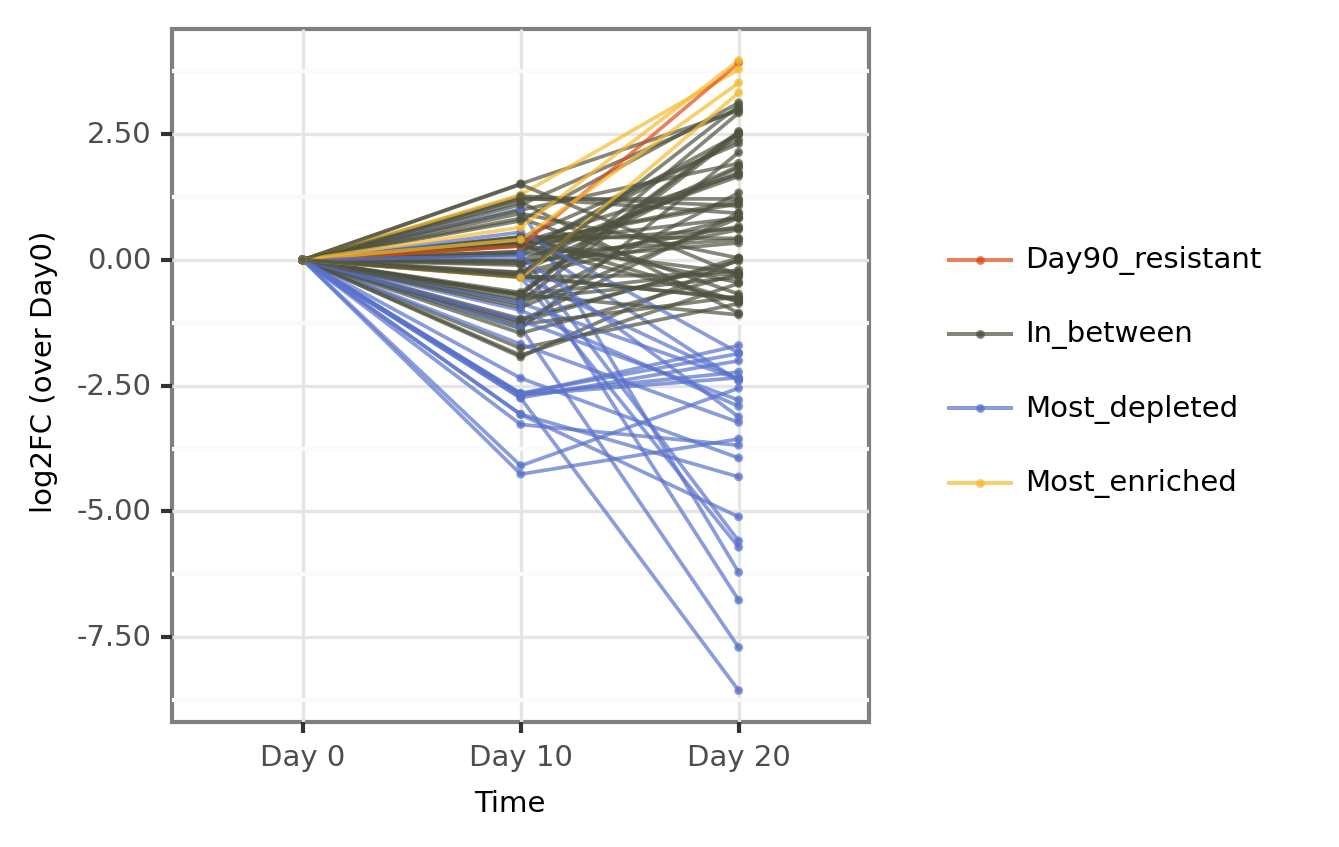

<ggplot: (2932098107140)>

In [31]:
plot=p9.ggplot(data=df_lineplot_melted[df_lineplot_melted['T3oak1to12_NumCells']>9])
plot+p9.aes(x='Time',y='logFC',group='LineageID',color='D20overD0') \
+ p9.geom_line(alpha=0.7) \
+ p9.geom_point(size=0.2, alpha=0.7) \
+ p9.themes.theme_bw() \
+ p9.theme(text=p9.element_text(size=7)) \
+ p9.scale_color_manual(values = {'In_between':'#4E523F','Most_enriched':'#F7BB2C','Most_depleted':'#5972CB','Day90_resistant':'#E24B15'}) \
+ p9.scale_x_discrete(limits = ["Day 0",'Day 10', "Day 20"]) \
+ p9.scale_y_continuous(breaks=[-10, -7.5, -5.0,-2.5,0.0,2.5,5.0],labels=lambda breaks: ["{:.2f}".format(val) for val in breaks]) \
+ p9.theme(text=p9.element_text(size=7),legend_title=p9.element_blank(),legend_key=p9.element_blank()) \
+ p9.ylab('log2FC (over Day0)') \
+ p9.theme(figure_size=(3,3)) # 3 inch

In [34]:
df_lineplot_melted[df_lineplot_melted['T3oak1to12_NumCells']>9][100:105]

,LineageID,Time,logFC,D20overD0,T3oak1to12_NumCells
150,GENBC0205301,Day 10,0.319279,In_between,340.0
151,GENBC0279596,Day 10,-1.281699,In_between,101.0
152,GENBC0271278,Day 10,-3.068933,Most_depleted,26.0
153,GENBC0212895,Day 10,-0.259722,In_between,177.0
154,GENBC0229590,Day 10,-4.091040,Most_depleted,12.0


In [36]:
df_lineplot_melted[df_lineplot_melted['T3oak1to12_NumCells']>9][['LineageID','Time','logFC','D20overD0']].to_csv(data_dir+'Fig3b.csv',header=True,index=False)

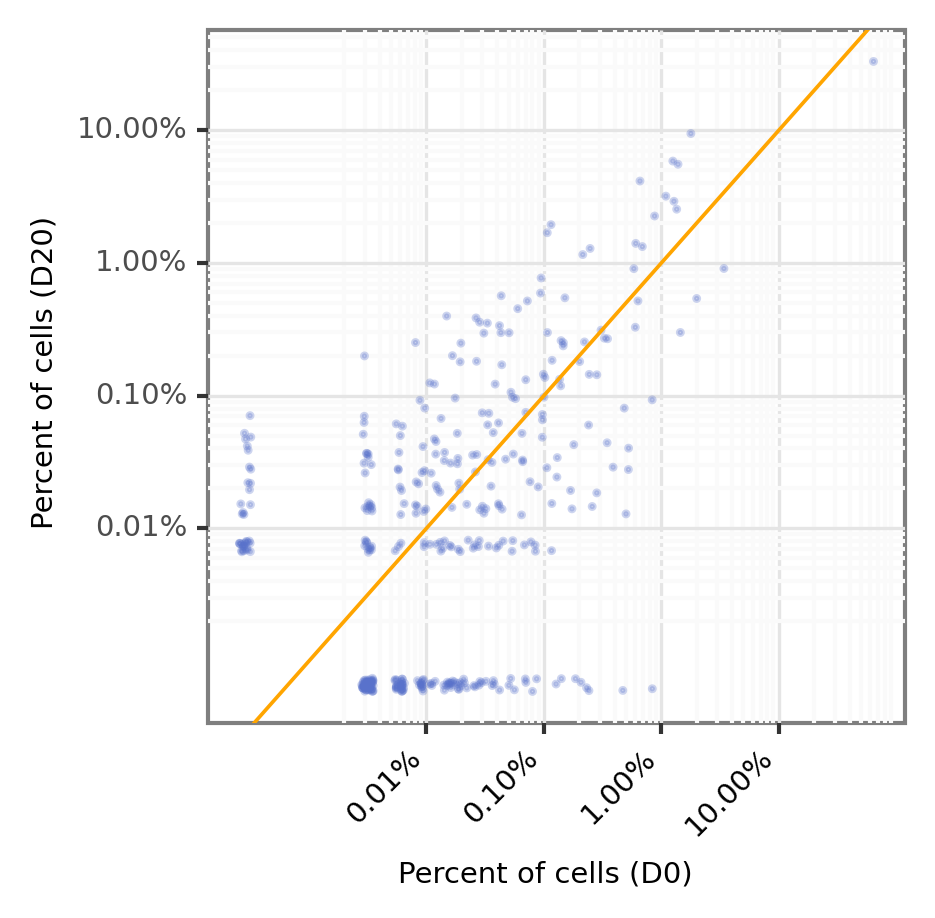

<ggplot: (2932098158484)>

In [38]:
plot=p9.ggplot(data=df_change,
           mapping=p9.aes(x='T0oak1to20_PctCells_adjusted',
                          y='D20_PctCells_adjusted',
                         ),
              )
plotsave=plot + p9.geom_point(alpha=0.3,size=0.2,color='#5972CB',position=p9.position_jitter(width=0.05, height=0.05)) \
     + p9.themes.theme_bw() \
     + p9.scales.scale_x_log10(labels=percent_format(),breaks=[0.0001,0.001,0.01,0.1]) \
     + p9.scales.scale_y_log10(labels=percent_format(),breaks=[0.0001,0.001,0.01,0.1]) \
     + p9.geom_abline(intercept=0, slope=1, colour="orange") \
     + p9.theme(text=p9.element_text(size=7)) \
     + p9.ylab('Percent of cells (D20)') \
     + p9.xlab('Percent of cells (D0)') \
     + p9.theme(axis_text_x=p9.element_text(colour="black",angle = 45, hjust = 1)) \
     + p9.theme(figure_size=(3,3))
plotsave

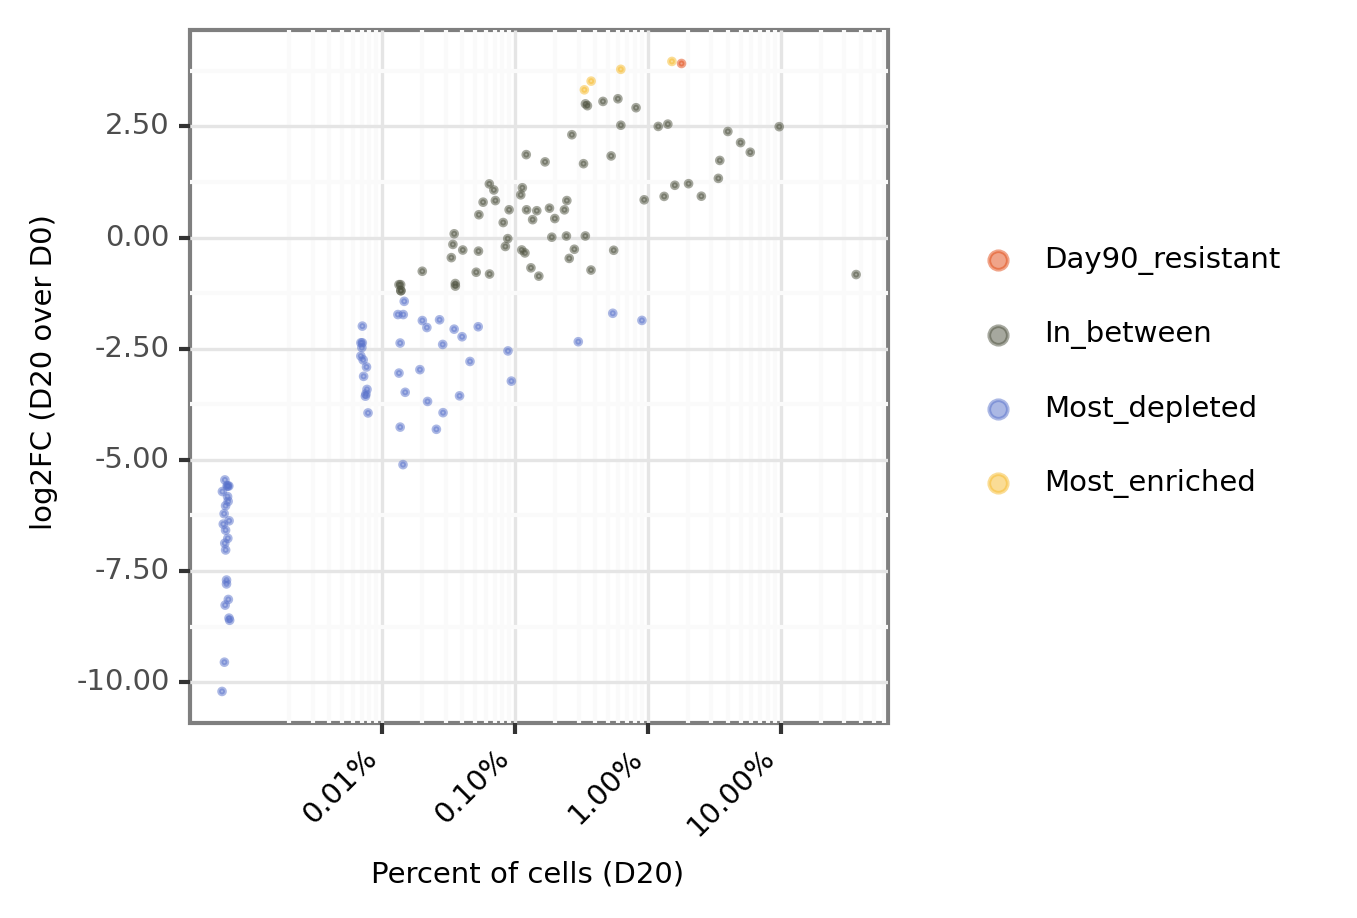

<ggplot: (2932043128025)>

In [39]:
plot=p9.ggplot(data=df_change[(df_change['T0oak1to20_NumCells']>9)],
           mapping=p9.aes(x='D20_PctCells_adjusted',
                          y='logFC_D20overD0',color='D20overD0'
                         ),
              )
plotsave=plot+p9.geom_point(alpha=0.5,size=0.3,position=p9.position_jitter(width=0.03, height=0)) \
+ p9.scale_color_manual(values = {'In_between':'#4E523F','Most_enriched':'#F7BB2C','Most_depleted':'#5972CB','Day90_resistant':'#E24B15'}) \
+ p9.themes.theme_bw() \
+ p9.scales.scale_x_log10(labels=percent_format(),breaks=[0.0001,0.001,0.01,0.1]) \
+ p9.scale_y_continuous(breaks=[-10, -7.5, -5.0,-2.5,0.0,2.5,5.0],labels=lambda breaks: ["{:.2f}".format(val) for val in breaks]) \
+ p9.ylab('log2FC (D20 over D0)') \
+ p9.xlab('Percent of cells (D20)') \
+ p9.theme(axis_text_x=p9.element_text(colour="black",angle = 45, hjust = 1)) \
+ p9.guides(color = p9.guide_legend(override_aes={'size' :2,'alpha':0.5 }),fill=p9.guide_legend(override_aes={'color': ['Most_depleted','In_between','Most_enriched','Future_resistant']})) \
+ p9.theme(text=p9.element_text(size=7),legend_title=p9.element_blank(),legend_key=p9.element_blank()) \
+ p9.theme(figure_size=(3,3)) # 3 inch
plotsave